# RouteFinder Quickstart Notebook

<a href="https://colab.research.google.com/github/ai4co/routefinder/blob/main/examples/1.quickstart.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"></a>

Uncomment and run the below cell for Google Colab

In [ ]:
# !git clone https://github.com/ai4co/routefinder.git
# %cd routefinder
# !pip install -e .[solver]

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from rl4co.utils.trainer import RL4COTrainer

from routefinder.models import RouteFinderBase, RouteFinderPolicy
from routefinder.envs.mtvrp import MTVRPEnv, MTVRPGenerator
from routefinder.utils import rollout, greedy_policy, evaluate

/home/botu/miniforge3/envs/routefinder/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Simple greedy (Nearest Neighbour) algorithm

Averaged cost: 16.589


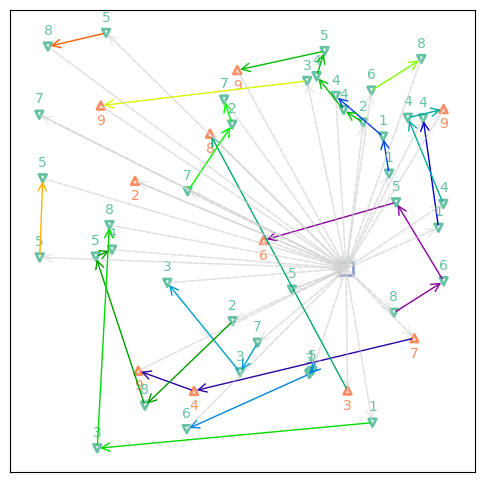

Cost:  24.32537078857422
Problem:  VRPBTW


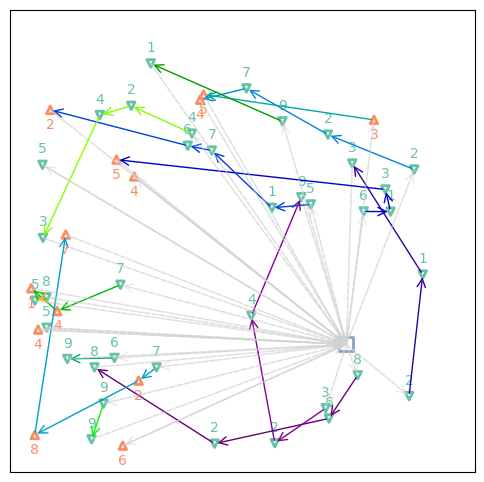

Cost:  29.257436752319336
Problem:  VRPBTW


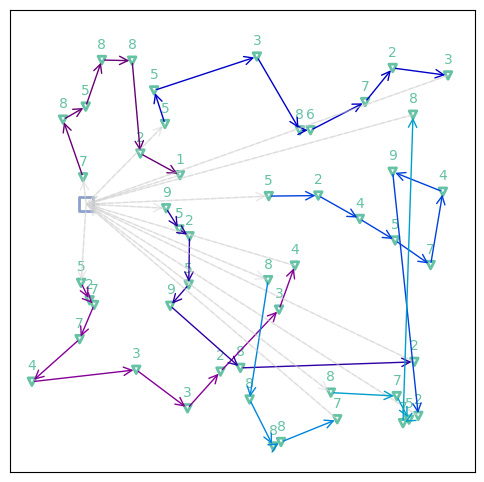

Cost:  13.960607528686523
Problem:  VRPL


In [2]:
# Sample all variants in the same batch (Mixed-Batch Training)
generator = MTVRPGenerator(num_loc=50, variant_preset="all")
env = MTVRPEnv(generator, check_solution=False)

# Generate data (mixed variants)
td_data = env.generator(32)
variant_names = env.get_variant_names(td_data)

td_test = env.reset(td_data)

actions = rollout(env, td_test.clone(), greedy_policy)
rewards_nearest_neighbor = env.get_reward(td_test, actions)

print(f"Averaged cost: {-rewards_nearest_neighbor.mean():.3f}")


for idx in [0, 1, 2]:
    env.render(td_test[idx], actions[idx])
    print("Cost: ", - rewards_nearest_neighbor[idx].item())
    print("Problem: ", variant_names[idx])

## RouteFinder

We divide RouteFinder into 
1. `policy` $\pi_\theta$ , i.e. neural network
2. `model` (`RouteFinderBase`), i.e. the RL algorithm. Note that this version is based on POMO training and Mixed-Batch Training (MBT) for variant sampling

In [3]:
# Policy: neural network, in this case with encoder-decoder architecture
policy = RouteFinderPolicy()

# Model: RL algorithm, in this case REINFORCE with POMO baseline
model = RouteFinderBase(env, 
                        policy,
                        batch_size=256,
                        train_data_size=100_000,
                        val_data_size=10_000,
                        optimizer_kwargs={"lr": 3e-4, "weight_decay": 1e-6},
) 

/home/botu/miniforge3/envs/routefinder/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'env' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['env'])`.
/home/botu/miniforge3/envs/routefinder/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'policy' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['policy'])`.


### Untrained rollout

Problem 1 | Cost: 34.645


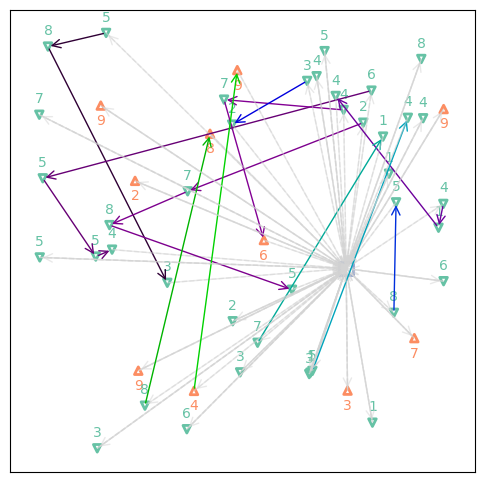

Problem 2 | Cost: 46.240


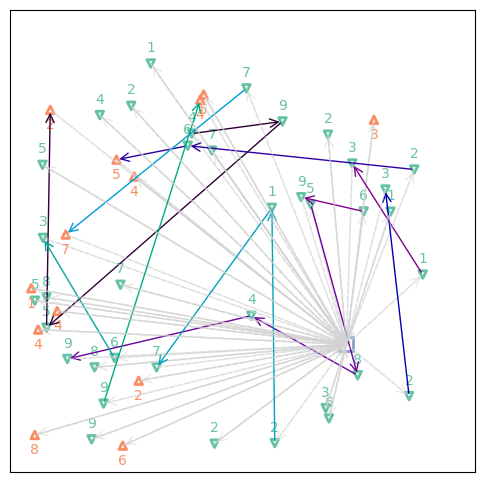

Problem 3 | Cost: 31.247


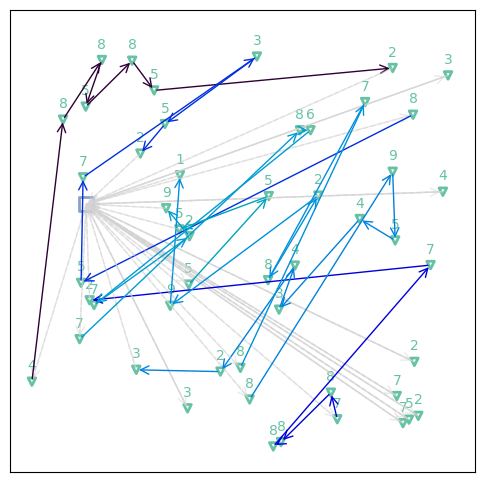

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

policy = policy.to(device)
out = policy(td_test.clone().to(device), env, phase="test", decode_type="greedy", return_actions=True)

actions_untrained = out['actions'].cpu().detach()
rewards_untrained = out['reward'].cpu().detach()

for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards_untrained[i]:.3f}")
    env.render(td_test[i], actions_untrained[i])

## Train

We run only few epochs for demonstration!

In [5]:
# Instantiate trainer based on RL4CO
trainer = RL4COTrainer(
    max_epochs=3,
    accelerator="gpu",
    devices=1,
    logger=None,
)

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/botu/miniforge3/envs/routefinder/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [6]:
trainer.fit(model)

Missing logger folder: /home/botu/Dev/routefinder/examples/lightning_logs


val_file not set. Generating dataset instead
test_file not set. Generating dataset instead
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params | Mode 
-------------------------------------------------------
0 | env      | MTVRPEnv          | 0      | train
1 | policy   | RouteFinderPolicy | 1.3 M  | train
2 | baseline | SharedBaseline    | 0      | train
-------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.159     Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/home/botu/miniforge3/envs/routefinder/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


/home/botu/miniforge3/envs/routefinder/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Epoch 2:   7%|▋         | 29/391 [00:08<01:41,  3.57it/s, v_num=0, train/reward=-13.8, train/loss=-0.69, val/reward=-13.2]  

/home/botu/miniforge3/envs/routefinder/lib/python3.11/site-packages/lightning/pytorch/trainer/call.py:54: Detected KeyboardInterrupt, attempting graceful shutdown...


### Model evaluation

Averaged cost: 11.804
Problem 1 | Cost: 18.852
Variant VRPBTW


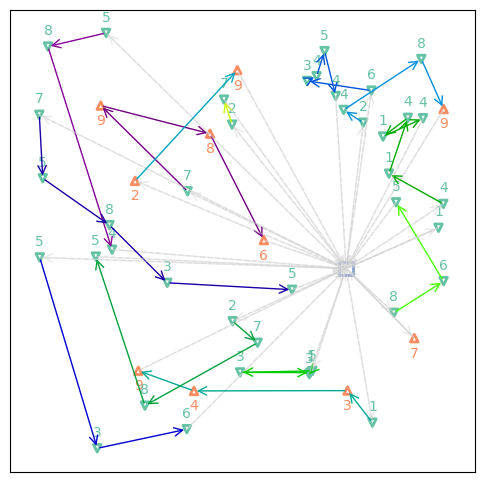

Problem 2 | Cost: 19.360
Variant VRPBTW


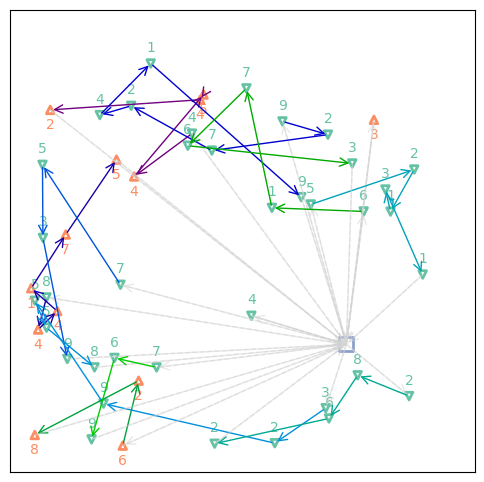

Problem 3 | Cost: 11.308
Variant VRPL


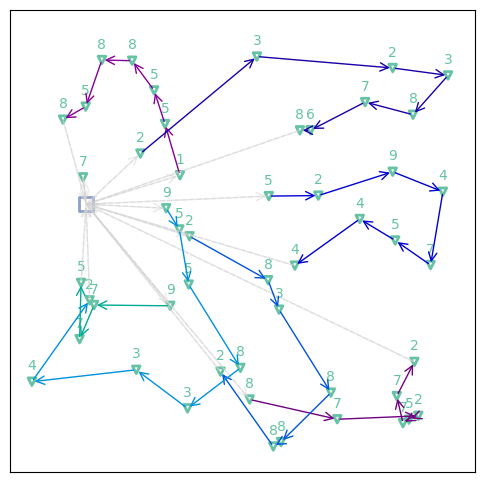

In [7]:
# Here we use `evaluate` to return the best augmented solution
td_test = td_test.to(device)
model = model.to(device)
out = evaluate(model, td_test.clone())

actions = out["best_aug_actions"]
rewards = env.get_reward(td_test, actions)

print(f"Averaged cost: {-rewards.mean():.3f}")

# Viz
for i in range(3):
    print(f"Problem {i+1} | Cost: {-rewards[i]:.3f}")
    print("Variant", env.get_variant_names(td_test[i]))
    env.render(td_test[i].cpu(), actions[i].cpu())

### Run PyVRP Baseline

We can additionally evaluate gaps by running the classical solver baselines such as the SOTA PyVRP and OR-Tools. 
Note that we also parallelize their evaluation across core for faster evaluation.

In [8]:
from routefinder.baselines.solve import solve

max_runtime = 10.0
num_procs = 32

actions_pyvrp, costs_pyvrp = solve(td_test, max_runtime=max_runtime, num_procs=num_procs, solver="pyvrp")
rewards_pyvrp = env.get_reward(td_test.clone().cpu(), actions_pyvrp)

print(f"Averaged cost PyVRP: {-rewards_pyvrp.mean():.3f}")

Averaged cost PyVRP: 11.043


In [9]:
def gap(sol, bks):
    return ((sol - bks) / bks).mean() * 100

print(f"Nearest Neighbor gap to HGS-PyVRP: {gap(rewards_nearest_neighbor.cpu(), rewards_pyvrp.cpu()):.3f}%")
print(f"RouteFinder gap to HGS-PyVRP: {gap(rewards.cpu(), rewards_pyvrp.cpu()):.3f}%")

Nearest Neighbor gap to HGS-PyVRP: 48.874%
RouteFinder gap to HGS-PyVRP: 7.720%


RouteFinder can find in just few epochs way better solutions than nearest neighbour heuristics! 🚀 